In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm

import dnnlib
from calibration.ece import ECE
from calibration.ReliabilityDiagram import ReliabilityDiagram
from data.classes import CIFAR10_CLASSES
from ema_pytorch import EMA
from training.diffusion import DDIMSampler

In [2]:
c = dnnlib.EasyDict()
c.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c.test_kwargs = dnnlib.EasyDict(
    test_dir="data/cifar10/test",
    run_dir="training-runs/00044-run",
)

c.model_kwargs = dnnlib.EasyDict(
    class_name="training.networks.EBMUNet",
    img_resolution=32,
    in_channels=3 + 2,
    model_channels=128,
    out_channels=10,
    label_dim=10,
    num_res_blocks=3,
    attn_resolutions=(2, 4),
    dropout_rate=0.3,
    channel_mult=(1, 2, 2, 2),
    conv_resample=True,
    dims=2,
    use_checkpoint=False,
    num_heads=4,
    num_head_channels=64,
    num_heads_upsample=-1,
    use_scale_shift_norm=False,
    resblock_updown=False,
    use_new_attention_order=True,
    context_dim=512,
    use_spatial_transformer=True,
    transformer_depth=1,
    pool="sattn",
)

net = dnnlib.util.construct_class_by_name(**c.model_kwargs).to(c.device).requires_grad_(False)
net = EMA(net).to(c.device).requires_grad_(False)

latest_ckpt = os.path.join(c.test_kwargs.run_dir, sorted([f for f in os.listdir(c.test_kwargs.run_dir) if f.endswith(".pt")])[-1])

print("Loading model from:", latest_ckpt)
ckpt = torch.load(latest_ckpt, map_location=c.device, weights_only=True)
net.load_state_dict(ckpt["ema"])
net.eval()

diffusion = DDIMSampler(model=net, schedule_name="cosine", timesteps=1000)

c.dataset_kwargs = dnnlib.EasyDict(
    class_name="training.dataset.ImageFolderDataset",
    path=c.test_kwargs.test_dir,
    use_labels=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
        ]
    ),
)
dataset_obj = dnnlib.util.construct_class_by_name(**c.dataset_kwargs)

c.dataloader_kwargs = dnnlib.EasyDict(
    class_name="torch.utils.data.DataLoader",
    dataset=dataset_obj,
    batch_size=128,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)
test_dataloader = dnnlib.util.construct_class_by_name(**c.dataloader_kwargs)

Loading model from: training-runs/00044-run/model-105000.pt


100%|██████████| 10/10 [00:05<00:00,  1.71it/s, Step=1, Sample=1]


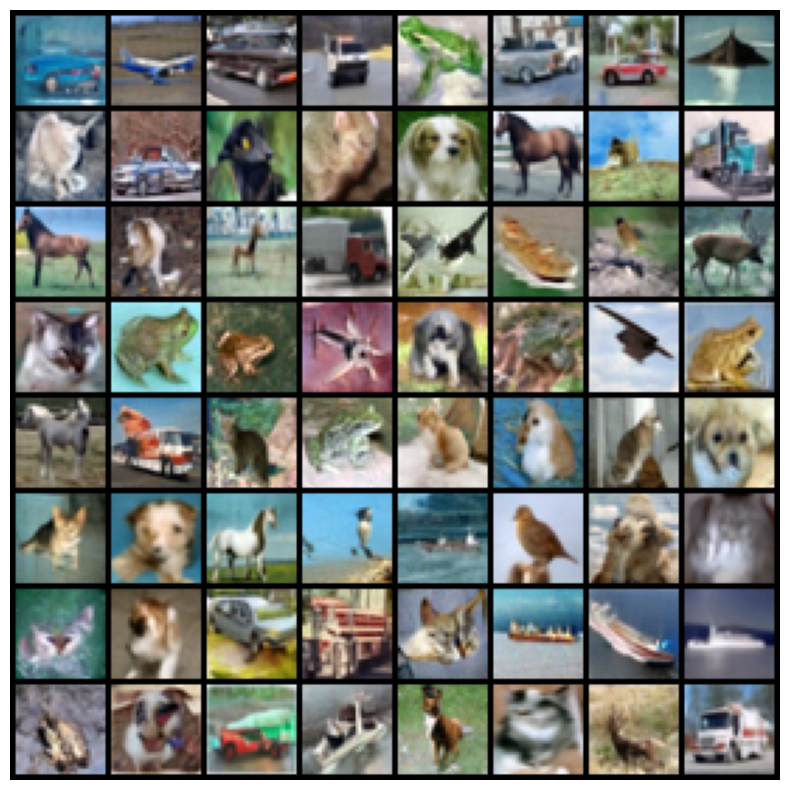

In [19]:
from torchvision.utils import make_grid

x_start, y_start, resolution, image_size = (0, 0, dataset_obj.resolution, dataset_obj.resolution)

x_pos = torch.arange(x_start, x_start + image_size).view(1, -1).repeat(image_size, 1)
y_pos = torch.arange(y_start, y_start + image_size).view(-1, 1).repeat(1, image_size)
x_pos = (x_pos / (resolution - 1) - 0.5) * 2.0
y_pos = (y_pos / (resolution - 1) - 0.5) * 2.0
pos = torch.stack([x_pos, y_pos], dim=0).to(c.device)

num_samples = 64
shape = (num_samples, 3, 32, 32)
pos = pos.unsqueeze(0).repeat(num_samples, 1, 1, 1)

class_labels = torch.randint(0, dataset_obj.label_dim, (num_samples,), device=c.device)

# x_t, pos, class_labels, steps: int = 1, method="linear", eta=0.0, only_return_x_0: bool = True, interval: int = 1
samples = diffusion(x_t=torch.randn(shape, device=c.device), pos=pos, class_labels=class_labels, steps=10, guidance_scale=1.3)
grid = make_grid(samples, nrow=8, normalize=True, scale_each=True)

plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

In [20]:
from training.patch import get_patches

def evaluate(net, dataloader, device, return_outputs=False):
    """Evaluate the model on the given dataset.

    :param net: The model to evaluate
    :param dataloader: The DataLoader object to use for evaluation
    :param device: The device to use for evaluation
    :param return_outputs: Whether to return the outputs or not

    :return: Tuple of (loss, accuracy, ece) or (loss, accuracy, ece, gts, confs, preds)
    """

    net.eval()
    ce_loss = torch.nn.CrossEntropyLoss(reduction="sum")
    ece_loss = ECE()

    loss_total, correct_total, samples_total = 0, 0, 0
    ece_total = 0

    if return_outputs:
        gts_all, confs_all, preds_all = [], [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            # Move data to the device
            images, labels = images.to(device), labels.to(device)

            # Process patches
            images = get_patches(images, image_size)
            batch_size = images.size(0)
            samples_total += batch_size

            # Forward pass
            clean_timesteps = torch.zeros(batch_size, dtype=torch.long, device=device)
            logits = net(images, clean_timesteps, cls_mode=True)

            # Compute loss
            labels_one_hot = labels.argmax(dim=1)
            loss = ce_loss(logits, labels_one_hot)
            loss_total += loss.item()

            # Compute probabilities and predictions
            probs = torch.nn.functional.softmax(logits, dim=1)
            conf, pred = probs.max(dim=1)

            correct_total += (pred == labels_one_hot).sum().item()
            ece_total += ece_loss.measure(probs.cpu().numpy(), labels_one_hot.cpu().numpy())

            if return_outputs:
                gts_all.append(labels_one_hot.cpu().numpy())
                confs_all.append(probs.cpu().numpy())
                preds_all.append(pred.cpu().numpy())

    # Compute averages
    loss_avg = loss_total / samples_total
    acc_avg = correct_total / samples_total
    ece_avg = ece_total / len(dataloader)

    if return_outputs:
        return (
            loss_avg,
            acc_avg,
            ece_avg,
            np.concatenate(gts_all),
            np.concatenate(confs_all),
            np.concatenate(preds_all),
        )

    return loss_avg, acc_avg, ece_avg


In [21]:
test_loss, test_acc, test_ece, gts, confs, preds = evaluate(
    net,
    test_dataloader,
    c.device,
    return_outputs=True,
)

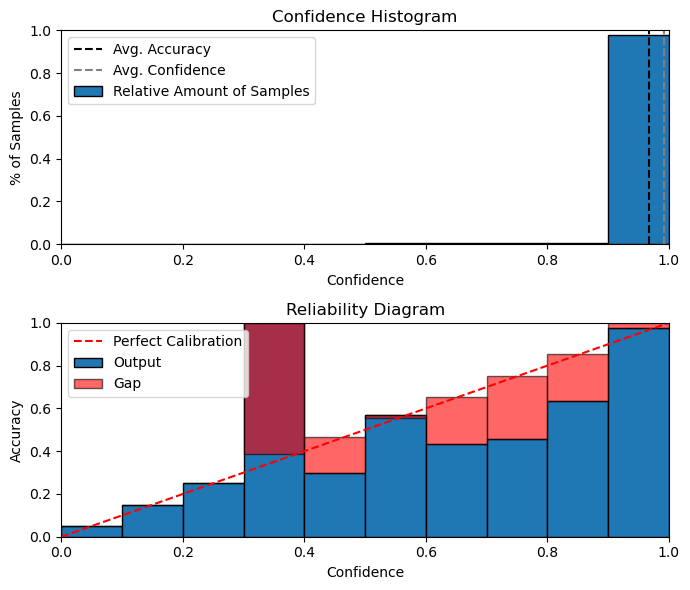

In [22]:
diagram = ReliabilityDiagram()
diagram.plot(confs, gts)
plt.show()

In [23]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test ECE: {test_ece:.4f}")

Test Loss: 0.1792
Test Accuracy: 0.9669
Test ECE: 0.0306


In [8]:
images, labels = [], []
for i, (image, label) in enumerate(test_dataloader):
    images.append(image)
    labels.append(label)

images = torch.cat(images)
labels = torch.cat(labels).argmax(dim=1).cpu().numpy()

In [9]:
def plot_samples(
    images: torch.Tensor,
    gts: np.ndarray,
    confs: np.ndarray,
    preds: np.ndarray,
    num_samples: int = 16,
):
    """Plot random samples from the dataset with predictions and confidences.

    :param images: Tensor of shape (N, C, H, W) containing images.
    :param gts: Tensor of shape (N,) containing ground truth labels.
    :param confs: Tensor of shape (N, C) containing confidences.
    :param preds: Tensor of shape (N,) containing predicted labels.
    :param num_samples: Number of samples to plot. Default is 16.
    """

    # Randomly choose num_sample indices from images, gts, preds, and confs
    indices = np.random.choice(len(images), num_samples, replace=False)

    images = images[indices]
    gts = gts[indices]
    preds = preds[indices]
    confs = confs[indices].max(axis=1)

    num_images = len(images)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10), dpi=150)
    axes = axes.flatten()

    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
        img = np.clip(img, 0, 1)

        pred_name = CIFAR10_CLASSES[preds[i]]
        true_name = CIFAR10_CLASSES[gts[i]]

        # Add color to title based on correctness
        color = "green" if preds[i] == gts[i] else "red"

        ax.imshow(img)
        ax.set_title(
            f"Pred: {pred_name}\nTrue: {true_name}\nConf: {confs[i]:.2f}",
            color=color,
        )
        ax.axis("off")

    for i in range(num_images, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

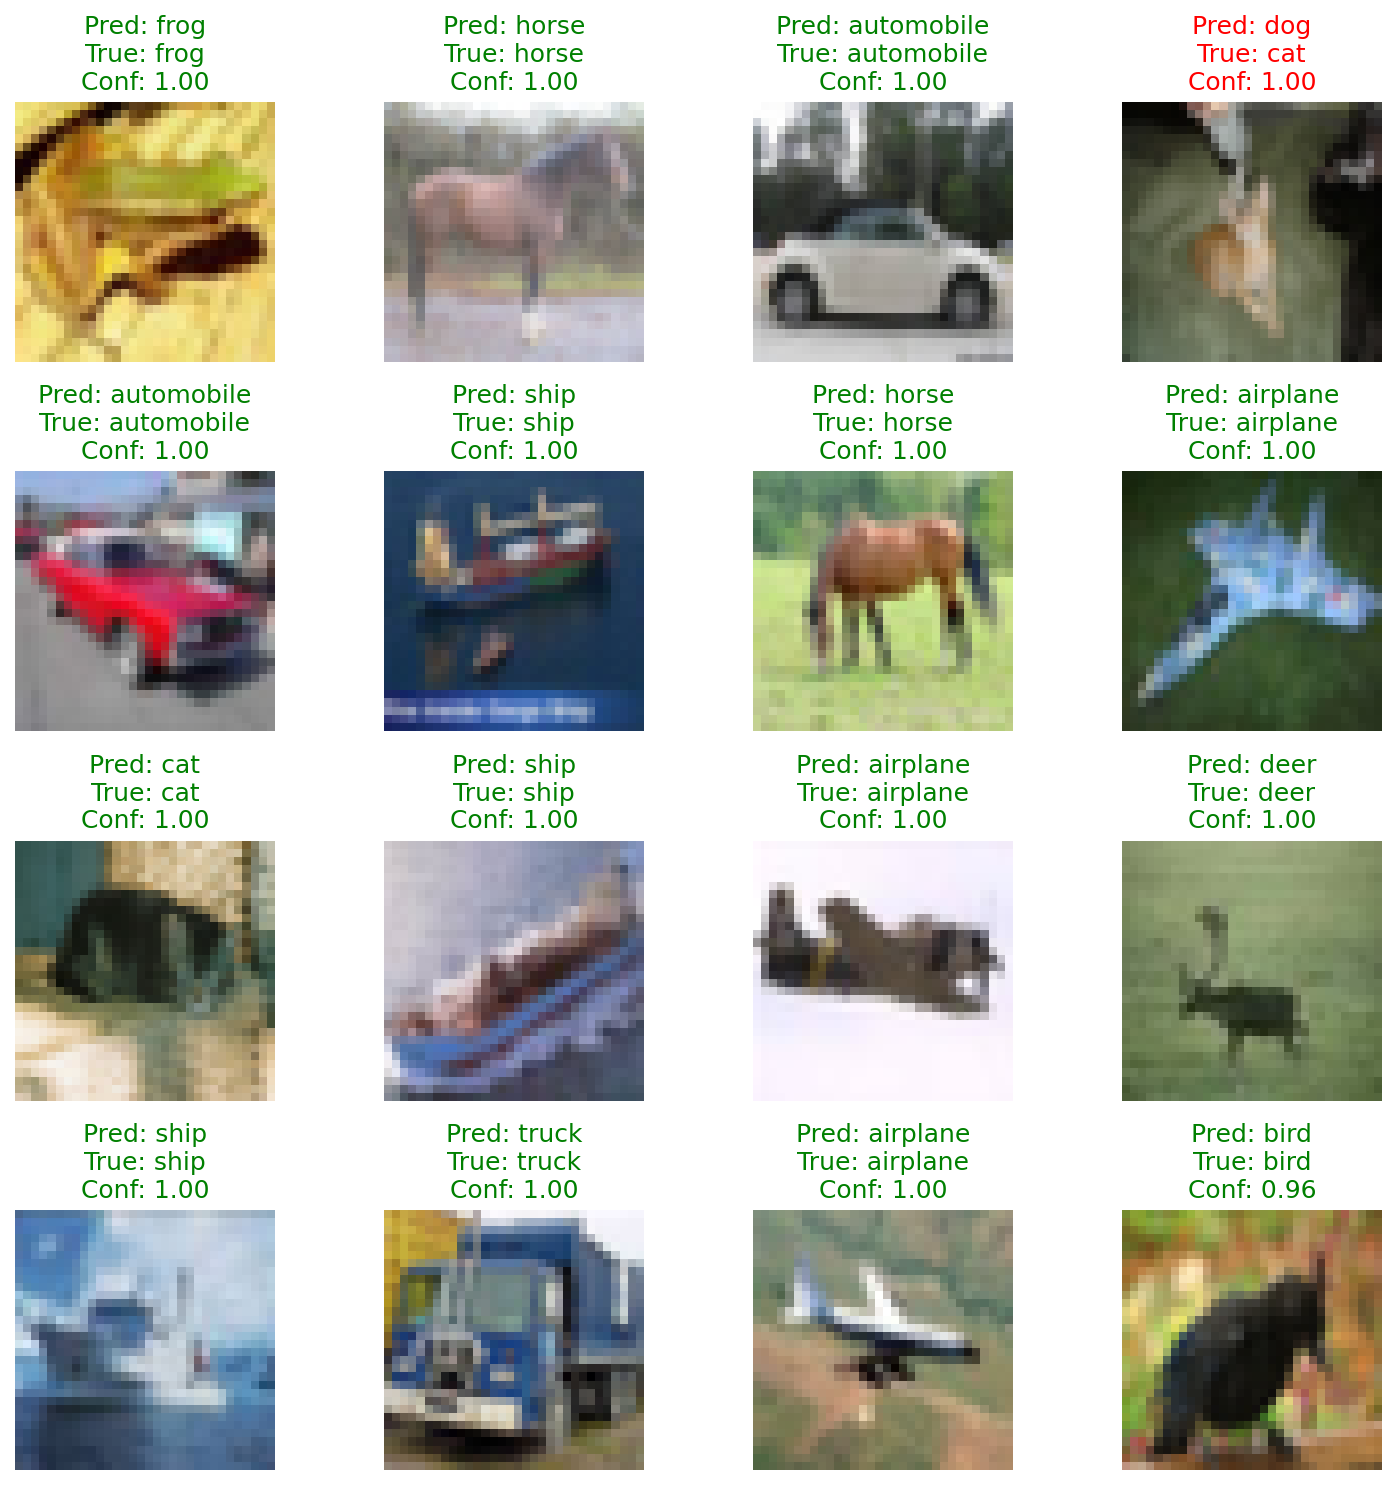

In [10]:
plot_samples(images, labels, confs, preds)